# Navigation

---

This is the first project of the Deep Reinforcement Learning (https://eu.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893)

Double DQN is applied to train the model.

Originally the Double DQN (DDQN) was introduced in https://arxiv.org/abs/1509.06461, 

and its main difference between DQN and DDQN is:

- DQN $R_{t+1}$ + $\gamma$ $\text{max}_a$ $Q\left(S_{t+1},a\right)$ 
- DDQN $R_{t+1}$ + $\gamma$ $Q\left(S_{t+1}, \text{argmax}_a Q(S_{t+1},a)\right)$,

and DDQN is less optimistic than DQN so that it is more unlikely to overestimate.



### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

ERROR: Invalid requirement: './python'
It looks like a path. File './python' does not exist.


The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/Users/SGnius/Downloads/deep-reinforcement-learning-master/p1_navigation/Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


When finished, you can close the environment.

In [7]:
env.close()

### 4. Train!

The model on fully connected layers is imported as model.

Import packages for training.

In [13]:
import random
import numpy as np
import torch
from collections import namedtuple, deque
import torch.nn.functional as F
import torch.optim as optim
from model import * 

Set hyperparameters

In [9]:
LR = 0.001             # Learning rate
BUFFER_SIZE = int(1e5) # Buffer size
GAMMA = 0.99           # discount factor
TAU = 1e-3             # tau factor for soft update
UPDATE_EVERY = 4       # update every
BATCH_SIZE = 64        # Batch size

Replay Buffer

In [10]:
class ReplayBuffer():
    
    def __init__(self, batch_size, buffer_size):
        self.batch_size = batch_size
        self.memory = deque(maxlen=buffer_size)
        self.experience = namedtuple('Experience', field_names=['state', 'action', 'reward', 'next_state', 'done'])
        
    def add(self, state, action, reward, next_action, done):
        e = self.experience(state, action, reward, next_action, done)
        self.memory.append(e)
    
    def sample(self):
        '''
        Returns sampled experiences and the sampling is performed with homogeneous weights.
        '''
        sample_size = self.batch_size
        sample_indices = random.choices(range(len(self.memory)), k=sample_size)
       
        experiences = np.array(self.memory)[sample_indices]
        
        states = torch.from_numpy(np.vstack([e[0] for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e[1] for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e[2] for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e[3] for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e[4] for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        return len(self.memory)

Construct a model

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class Agent():
    def __init__(self, state_size, action_size, seed):
        '''
        Initialize an Agent object.
        
        Params
        ======
        state_size (int) : dimension of each state
        action_size (int) : dimension of each action
        seed (int) : random seed
        '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
        
        # Replay memory
        self.memory = ReplayBuffer(BATCH_SIZE,BUFFER_SIZE)
        self.t_step = 0
                
    def act(self, state, eps=0.):
        '''
        Returns actions for given state as per current policy.
        Params
        ======
            state (array_like) : current state
            eps (float) : epsilon for e-greedy action selection
        '''
        state = np.array(state)
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        self.qnetwork_target.eval()
        
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()
        
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        
        
    def step(self, state, action, reward, next_state, done):
        # save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE-EVERY time steps
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        
        if self.t_step == 0:
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)
        

    def learn(self, experiences, gamma):
        '''
        Update value parameters using given batch of experience tuples.
        Params
        =====
            experiences (Tuple[torch.Variable]) :  tuple of (s, a, r, s', done) tuples
            gamma (flaot) : discount factor
        '''
        
        # Get sampled experiences
        states, actions, rewards, next_states, dones = experiences
        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        
        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        
        
        # Get next action
        next_action = self.qnetwork_local.forward(next_states).max(dim=1)[1].to(device).data.view(-1, 1) # Batch_size x 1
              
        Q_list = self.qnetwork_target.forward(next_states)
        DQQ = torch.gather(Q_list, 1, next_action)
        
        # Q targets
        Q_targets = rewards + (gamma * DQQ * (1-dones))

        # Compute loss
        loss = F.mse_loss(Q_targets, Q_expected)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU) 
        
    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0 - tau) * target_param.data)

In [14]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0)

Train!

In [8]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        #state = env.reset()
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            
            action = agent.act(state, eps) 
            # send the action to the environment
            env_info = env.step(action)[brain_name] 
            # get the next state
            next_state = env_info.vector_observations[0]
            # get the reward
            reward = env_info.rewards[0]
            # see if episode has finished 
            done = env_info.local_done[0]
            #action = agent.act(state, eps)
            #next_state, reward, done, _ = env.step(action)
            
            #step
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores= dqn()

Episode 100	Average Score: 0.33
Episode 200	Average Score: 3.14
Episode 300	Average Score: 7.53
Episode 400	Average Score: 9.05
Episode 500	Average Score: 11.29
Episode 576	Average Score: 13.04
Environment solved in 476 episodes!	Average Score: 13.04


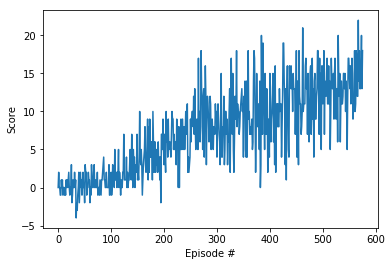

In [12]:
import matplotlib.pyplot as plt
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

# Watch the performance of a trained model

In [16]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth',map_location='cpu'))

In [18]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/Users/SGnius/Downloads/deep-reinforcement-learning-master/p1_navigation/Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [19]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent.act(state)                      # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 11.0


In [ ]:
env.close()

# Future Idea

- Replay buffer might speed up the learning since it enalbes to sample more important ones.
- The rainbow algorithm may perform better (https://arxiv.org/abs/1710.02298)
- Besides of these, increasing batch size may be helpful for obtaining better performce since the samples would be less correlated, and it can lead to less biased sampling.